In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

In [ ]:
# !pip install -q torch_geometric
# !pip install -q class_resolver
# !pip3 install pymatting

In [140]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
# import util
from PIL import Image
# import cv2
import matplotlib.pyplot as plt
from numpy import asarray
import tifffile as tiff
import torch.nn as nn
import torch.nn.functional as nnFn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.manifold import TSNE
import random
from torch_geometric.nn import ARMAConv
import copy

In [142]:
fa_feature_path = "/home/snu/Downloads/Histogram_CN_FA_20bin_updated.npy"
Histogram_feature_CN_FA_array = np.load(fa_feature_path, allow_pickle=True)

# Load AD features
fa_feature_path = "/home/snu/Downloads/Histogram_AD_FA_20bin_updated.npy"
Histogram_feature_AD_FA_array = np.load(fa_feature_path, allow_pickle=True)

# Combine features and labels
X = np.vstack([Histogram_feature_CN_FA_array, Histogram_feature_AD_FA_array])
y = np.hstack([
    np.zeros(Histogram_feature_CN_FA_array.shape[0], dtype=np.int64),
    np.ones(Histogram_feature_AD_FA_array.shape[0], dtype=np.int64)
])
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
num_nodes, num_feats = X.shape
print(f"Features: {X.shape}, Labels: {y.shape}")

Features: (223, 180), Labels: (223,)


## 1 layer

In [ ]:
def sim(h1, h2, tau = 0.2):
    z1 = nnFn.normalize(h1, dim=-1, p=2)
    z2 = nnFn.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag()))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / cross_sim.sum(dim=-1))

In [ ]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(), # nn.ELU()
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class ARMAEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ="ELU", num_stacks=1, num_layers=1):
        super(ARMAEncoder, self).__init__()
        self.device = device
        # Define all activation functions
        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "ELU": nnFn.elu,
            "RELU": nnFn.relu
        }
        # Get the activation function based on the input string
        self.act = activations.get(activ, nnFn.elu)

        self.arma = ARMAConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,   # number of parallel stacks
            num_layers=num_layers,   # depth per stack
            act=self.act,               # nonlinearity inside ARMA
            shared_weights=True,     # weight sharing across layers
            dropout=0.25             # ARMA-internal dropout
        )
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.arma(x, edge_index)
        x = self.dropout(x)
        x = self.batchnorm(x)
        logits = self.mlp(x)
        return logits

In [ ]:
class EMA(): # Moving Average update

    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        # old: old model parameter
        # new: new model parameter
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [ ]:
class ARMA(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.5, cut=True):
        super(ARMA, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        self.beta = 0.6

        # Use ARMA encoder instead of GCN encoder
        self.online_encoder = ARMAEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "RELU": nnFn.relu
        }
        self.act = activations.get(activ, nnFn.elu)

        # Predictor head
        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)

        # Loss selection
        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        x1 = self.online_encoder(data1)
        logits1 = self.online_predictor(x1)
        S1 = nnFn.softmax(logits1, dim=1)

        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnFn.softmax(logits2, dim=1)

        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()

        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)

        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)

        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)

        I_S = torch.eye(self.num_clusters, device=self.device)
        # k = torch.norm(I_S)
        k = torch.tensor(self.num_clusters, device=self.device, dtype=torch.float32)
        n = S.shape[0]

        modularity_term = (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1

        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)

        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / den)

        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / torch.norm(St_S) - I_S / torch.norm(I_S))

        return mincut_loss + ortho_loss

In [ ]:
def create_adj(features, cut, alpha=1.0):
    """Return a dense W0 matrix (only once), as you originally used for A1 / unsup loss.
       We still create the dense matrix once, but all augmentations below work with edge_index.
    """
    F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
    W = np.dot(F_norm, F_norm.T)

    if cut == 0:
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        W = (W / W.max()).astype(np.float32)
    else:
        W = (W * (W >= alpha)).astype(np.float32)
    return W

In [ ]:
def edge_index_from_dense(W):
    """Return edge_index as numpy array shape (2, E) and edge_weight vector."""
    rows, cols = np.nonzero(W > 0)
    edge_index = np.vstack([rows, cols]).astype(np.int64)
    edge_weight = W[rows, cols].astype(np.float32)
    return edge_index, edge_weight

In [ ]:
def build_adj_list(edge_index_np, num_nodes):
    """Build adjacency list: list of neighbor arrays for each node (numpy)."""
    adj = [[] for _ in range(num_nodes)]
    src = edge_index_np[0]
    dst = edge_index_np[1]
    for s, d in zip(src, dst):
        adj[s].append(d)
    # convert to numpy arrays for speed
    adj = [np.array(neis, dtype=np.int64) if len(neis) > 0 else np.array([], dtype=np.int64) for neis in adj]
    return adj

In [ ]:
def aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=None):
    """Randomly drop edges from edge_index. Returns new edge_index (2 x E') and edge_weight placeholder."""
    rng = np.random.default_rng(seed)
    E = edge_index_np.shape[1]
    keep_mask = rng.random(E) >= drop_percent
    new_edge_index = edge_index_np[:, keep_mask]
    return new_edge_index

In [ ]:
def aug_subgraph_edge_index(features_np, edge_index_np, adj_list, drop_percent=0.2, seed=None):
    """
    Sample a subgraph by selecting s_node_num nodes via neighbor expansion (BFS-like),
    then return (sub_features, sub_edge_index) with node ids remapped to [0..s-1].
    """
    rng = np.random.default_rng(seed)
    num_nodes = features_np.shape[0]
    s_node_num = int(num_nodes * (1 - drop_percent))
    if s_node_num < 1:
        s_node_num = 1

    # choose a random center node
    center_node = int(rng.integers(0, num_nodes))
    sub_nodes = [center_node]
    front_idx = 0

    # BFS-like expansion using adjacency list until we reach s_node_num
    while len(sub_nodes) < s_node_num and front_idx < len(sub_nodes):
        cur = sub_nodes[front_idx]
        neighbors = adj_list[cur]
        if neighbors.size > 0:
            # shuffle neighbors and try to add new ones
            nbrs_shuffled = neighbors.copy()
            rng.shuffle(nbrs_shuffled)
            for nb in nbrs_shuffled:
                if nb not in sub_nodes:
                    sub_nodes.append(int(nb))
                    if len(sub_nodes) >= s_node_num:
                        break
        front_idx += 1
        # if BFS stalls (no new neighbors), add random nodes
        if front_idx >= len(sub_nodes) and len(sub_nodes) < s_node_num:
            remaining = [n for n in range(num_nodes) if n not in sub_nodes]
            if not remaining:
                break
            add = int(rng.choice(remaining))
            sub_nodes.append(add)

    sub_nodes = sorted(set(sub_nodes))
    node_map = {old: new for new, old in enumerate(sub_nodes)}

    # induce edges that have both ends in sub_nodes
    src = edge_index_np[0]
    dst = edge_index_np[1]
    mask_src_in = np.isin(src, sub_nodes)
    mask_dst_in = np.isin(dst, sub_nodes)
    mask = mask_src_in & mask_dst_in
    sel_src = src[mask]
    sel_dst = dst[mask]
    # remap
    remapped_src = np.array([node_map[int(s)] for s in sel_src], dtype=np.int64)
    remapped_dst = np.array([node_map[int(d)] for d in sel_dst], dtype=np.int64)
    new_edge_index = np.vstack([remapped_src, remapped_dst])
    # sub features
    sub_features = features_np[sub_nodes, :].astype(np.float32)
    return sub_features, new_edge_index

In [ ]:
def load_data_from_edge_index(node_feats_np, edge_index_np, device):
    """Return PyG Data with torch tensors. edge_index_np is (2, E) numpy."""
    node_feats = torch.from_numpy(node_feats_np).float()
    edge_index = torch.from_numpy(edge_index_np.astype(np.int64)).long()
    return node_feats, edge_index

# Data Loading and preprocessing

In [ ]:
print("CN Shape:", Histogram_feature_CN_FA_array.shape)
print("AD Shape:",Histogram_feature_AD_FA_array.shape)

CN Shape: (133, 180)
AD Shape: (90, 180)


In [ ]:
features = X
#features = np.concatenate((Histogram_feature_CN_FA_array, Histogram_feature_MCI_FA_array), axis=0)
features = features.astype(np.float32)
print(features.shape, features.dtype)

(223, 180) float32


In [ ]:
# cut = 0  # Consider n-cut loss OR Modularity loss
# alpha = 0.9 # Edge creation Threshold
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# feats_dim = 180  # 20-bin
# K = 2  # Number of clusters
# epoch = [2500, 60, 100]  # Training epochs for different phases

# # Define all activation functions to test
# define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
# activ = "ELU"

In [ ]:
# Required Parameters
cut = 0  # Consider n-cut loss OR Modularity loss
alpha = 0.8 # Edge creation Threshold
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feats_dim = 180  # 20-bin
K = 2  # Number of clusters
epoch = [2500, 60, 100]  # Training epochs for different phases

# Define all activation functions to test
define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
activ = "SELU"

In [ ]:
print(features.shape)

(223, 180)


In [ ]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(np.array(np.nonzero(W>0.6)).shape)

(2, 49259)


In [ ]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(W)

[[1.0000001  0.8858711  0.8792206  ... 0.8945457  0.8821603  0.902783  ]
 [0.8858711  1.0000001  0.9067889  ... 0.8917234  0.88389105 0.9146811 ]
 [0.8792206  0.9067889  0.9999999  ... 0.87847316 0.90214026 0.92830694]
 ...
 [0.8945457  0.8917234  0.87847316 ... 1.0000002  0.8659749  0.91381127]
 [0.8821603  0.88389105 0.90214026 ... 0.8659749  1.         0.8924861 ]
 [0.902783   0.9146811  0.92830694 ... 0.91381127 0.8924861  1.        ]]


In [ ]:
W0 = create_adj(features, cut, alpha)  # shape (N, N) dense
A1 = torch.from_numpy(W0).float().to(device)

edge_index_np, edge_weight_np = edge_index_from_dense(W0)  # numpy edge_index (2, E)
num_nodes = features.shape[0]
adj_list = build_adj_list(edge_index_np, num_nodes)  # adjacency list for fast subgraph sampling

# convert features to numpy (we'll slice them in augmentations)
features_np = features.copy()

# Build initial Data object (full graph)
node_feats_full, edge_index_full = load_data_from_edge_index(features_np, edge_index_np, device)
data0 = Data(x=node_feats_full.to(device), edge_index=edge_index_full.to(device))
print("Data0:", data0)

Data0: Data(x=[223, 180], edge_index=[2, 41689])


# Model initialization

## Contrastive Loss

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.nn as nn

model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
criterion = nn.CrossEntropyLoss()

num_epochs = 5000
lambda_contrastive = 0.1
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
for epoch in range(num_epochs):
    # --- Augmentations using edge_index or adjacency list (fast, sparse) ---
    # 1) Random edge drop on edge_index
    W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

    # 2) Subgraph via adjacency list (returns sub_features and sub_edge_index)
    W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)
    features_aug2 = features_np.copy()

    # 3) Feature augmentations (keep these as numpy operations)
    # Feature dropout (column-wise)
    rng = np.random.default_rng(epoch)
    mask = rng.random(features_np.shape) >= 0.2
    features_aug1 = (features_np * mask.astype(np.float32))

    # Feature cell dropout (random cell zeroing)
    aug_feat2 = features_np.copy()
    num_nodes_local, feat_dim = aug_feat2.shape
    drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
    # random positions to zero
    flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
    rows = (flat_idx // feat_dim)
    cols = (flat_idx % feat_dim)
    aug_feat2[rows, cols] = 0.0
    features_aug2_feat = aug_feat2.astype(np.float32)

    # --- Build PyG Data objects for the two views ---
    # view1: features_aug1 with W_aug1_edge_index
    node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
    data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

    # view2: features_aug2 (from subgraph) and its edge_index
    node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
    data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

    # --- Training step ---
    model.train()
    optimizer.zero_grad()

    S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

    unsup_loss = model.loss(A1, logits1)
    cont_loss = ((l1 + l2) / 2).mean()
    total_loss = unsup_loss + lambda_contrastive * cont_loss

    total_loss.backward()
    optimizer.step()
    scheduler.step()
    model.update_ma()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

Epoch 0 | Total: 0.3064 | Unsup: -0.2385 | Cont: 5.4490
Epoch 100 | Total: 0.0065 | Unsup: -0.4902 | Cont: 4.9670
Epoch 200 | Total: -0.0425 | Unsup: -0.5118 | Cont: 4.6929
Epoch 300 | Total: -0.0451 | Unsup: -0.5090 | Cont: 4.6395
Epoch 400 | Total: -0.0579 | Unsup: -0.5152 | Cont: 4.5730
Epoch 500 | Total: -0.0655 | Unsup: -0.5187 | Cont: 4.5317
Epoch 600 | Total: -0.0653 | Unsup: -0.5121 | Cont: 4.4680
Epoch 700 | Total: -0.0814 | Unsup: -0.5251 | Cont: 4.4373
Epoch 800 | Total: -0.0754 | Unsup: -0.5264 | Cont: 4.5099
Epoch 900 | Total: -0.0812 | Unsup: -0.5261 | Cont: 4.4493
Epoch 1000 | Total: -0.0733 | Unsup: -0.5188 | Cont: 4.4546
Epoch 1100 | Total: -0.0743 | Unsup: -0.5198 | Cont: 4.4557
Epoch 1200 | Total: -0.0461 | Unsup: -0.4915 | Cont: 4.4536
Epoch 1300 | Total: -0.0665 | Unsup: -0.5083 | Cont: 4.4184
Epoch 1400 | Total: -0.0773 | Unsup: -0.5181 | Cont: 4.4075
Epoch 1500 | Total: -0.0690 | Unsup: -0.5140 | Cont: 4.4502
Epoch 1600 | Total: -0.0583 | Unsup: -0.5058 | Cont: 4

In [ ]:
model.eval()
with torch.no_grad():
        S1, _, logits1,_,_,_ = model(data0, data0)
        y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
        y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
        print(y_pred)
        print(y_pred_proba.max(axis=-1))

[1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0
 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1
 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0
 1]
[0.9990884  0.9995722  0.9892763  0.9999994  0.9965329  0.99999475
 0.5477809  0.6449323  0.9957417  0.9999845  0.9999999  0.9970132
 0.9998394  0.99873716 0.9965179  0.9994842  0.9989318  0.99910825
 0.9491132  0.99999976 0.99658185 0.9997204  0.9999505  1.
 0.9993513  1.         1.         0.79656154 0.9998123  0.99999833
 0.99835193 0.9985353  1.         0.9999988  1.         1.
 0.9829858  0.9061363  0.9996704  1.         0.9999999  0.86354846
 1.         0.5802946  0.9999932  0.99995744 0.9985083  0.9999937
 0.99999857 0.9999999  0.982

In [ ]:
acc_score = accuracy_score(y, y_pred)
acc_score_inverted = accuracy_score(y, 1 - y_pred)

print("Accuracy Score:", acc_score)
print("Accuracy Score Inverted:", acc_score_inverted)

if acc_score_inverted > acc_score:
    acc_score = acc_score_inverted
    y_pred = 1 - y_pred

prec_score = precision_score(y, y_pred)
rec_score = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
log_loss_value = log_loss(y, y_pred_proba)

print("Precision Score:", prec_score)
print("Recall Score:", rec_score)
print("F1 Score:", f1)
print("Log Loss:", log_loss_value)

Accuracy Score: 0.23318385650224216
Accuracy Score Inverted: 0.7668161434977578
Precision Score: 0.6759259259259259
Recall Score: 0.8111111111111111
F1 Score: 0.7373737373737373
Log Loss: 7.448655170928875


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp
from copy import deepcopy
from typing import Dict, List

# -------------------- Hyperparameters --------------------
num_runs = 10
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
lambda_list = [0.5]
base_seed = 42
eval_every_epochs = 100  # set to None to evaluate only at end of each run

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_results: List[Dict] = []

# -------------------- Loop over different lambda values --------------------
for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")

    # store per-lambda per-run metrics
    acc_scores: List[float] = []
    prec_scores: List[float] = []
    rec_scores: List[float] = []
    f1_scores: List[float] = []
    log_losses: List[float] = []

    for run in range(num_runs):
        # -------------------- Reproducibility --------------------
        seed = base_seed + run
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        print(f"\n--- Run {run+1}/{num_runs} (seed={seed}) ---")


        model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        lambda_contrastive = lam  # use current lambda

        # optional periodic evaluation accumulation (if you prefer)
        per_run_accs: List[float] = []
        per_run_precs: List[float] = []
        per_run_recs: List[float] = []
        per_run_f1s: List[float] = []
        per_run_log_losses: List[float] = []

        # -------------------- Training loop --------------------
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

            # 2) Another edge drop (or subgraph)
            W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

            # 3) Feature augmentations (numpy ops)
            rng = np.random.default_rng(seed + epoch)
            mask = rng.random(features_np.shape) >= 0.2
            features_aug1 = (features_np * mask.astype(np.float32))

            # Feature cell dropout (random cell zeroing)
            aug_feat2 = features_np.copy()
            num_nodes_local, feat_dim = aug_feat2.shape
            drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
            if drop_feat_num > 0:
                flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
                rows = (flat_idx // feat_dim)
                cols = (flat_idx % feat_dim)
                aug_feat2[rows, cols] = 0.0
            features_aug2 = aug_feat2.astype(np.float32)

            # --------------------
            # Build PyG Data objects for the two views
            # --------------------
            node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
            data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

            node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
            data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

            # --------------------
            # Forward pass and losses
            # --------------------
            # Expected model output: S1, S2, logits1, logits2, l1, l2
            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            # TODO: adapt model.loss call to your implementation.
            # The original code used `unsup_loss = model.loss(A1, logits1)`.
            # If your loss expects adjacency or labels, provide A1 or appropriate input.
            unsup_loss = model.loss(A1, logits1)  # <-- ensure A1 is defined appropriately

            cont_loss = 0.5 * (l1 + l2).mean()
            total_loss = unsup_loss + lambda_contrastive * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Optional: if your model uses EMA updates
            if hasattr(model, "update_ma"):
                model.update_ma()

            # Periodic console logging
            if (eval_every_epochs is not None and epoch % eval_every_epochs == 0) or (epoch == num_epochs - 1):
                print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

                # -------------------- Periodic evaluation (optional) --------------------
                # Evaluate on data0 (full graph) if available
                if 'data0' in globals():
                    model.eval()
                    with torch.no_grad():
                        # Using data0 twice (as in your original script)
                        S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                        y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                        y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()

                        # If labels 'y' are torch tensor, convert to numpy
                        y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                        # check inverted labeling (keeps same behavior you had)
                        acc_score = accuracy_score(y_true, y_pred)
                        acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                        if acc_score_inverted > acc_score:
                            acc_score = acc_score_inverted
                            y_pred = 1 - y_pred

                        prec_score = precision_score(y_true, y_pred, zero_division=0)
                        rec_score = recall_score(y_true, y_pred, zero_division=0)
                        f1 = f1_score(y_true, y_pred, zero_division=0)
                        try:
                            log_loss_value = log_loss(y_true, y_pred_proba)
                        except ValueError:
                            # fallback if probabilities are degenerate
                            log_loss_value = float("nan")

                        per_run_accs.append(acc_score)
                        per_run_precs.append(prec_score)
                        per_run_recs.append(rec_score)
                        per_run_f1s.append(f1)
                        per_run_log_losses.append(log_loss_value)

        # -------------------- End of epochs for this run --------------------
        # Final evaluation at end of run if no periodic eval was run
        if len(per_run_accs) == 0 and 'data0' in globals():
            model.eval()
            with torch.no_grad():
                S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()
                y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                acc_score = accuracy_score(y_true, y_pred)
                acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                if acc_score_inverted > acc_score:
                    acc_score = acc_score_inverted
                    y_pred = 1 - y_pred

                prec_score = precision_score(y_true, y_pred, zero_division=0)
                rec_score = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                try:
                    log_loss_value = log_loss(y_true, y_pred_proba)
                except ValueError:
                    log_loss_value = float("nan")

                per_run_accs.append(acc_score)
                per_run_precs.append(prec_score)
                per_run_recs.append(rec_score)
                per_run_f1s.append(f1)
                per_run_log_losses.append(log_loss_value)

        # Aggregate run results (mean of periodic evals if there were multiple)
        run_acc = float(np.mean(per_run_accs)) if len(per_run_accs) > 0 else float('nan')
        run_prec = float(np.mean(per_run_precs)) if len(per_run_precs) > 0 else float('nan')
        run_rec = float(np.mean(per_run_recs)) if len(per_run_recs) > 0 else float('nan')
        run_f1 = float(np.mean(per_run_f1s)) if len(per_run_f1s) > 0 else float('nan')
        run_logloss = float(np.nanmean(per_run_log_losses)) if len(per_run_log_losses) > 0 else float('nan')

        acc_scores.append(run_acc)
        prec_scores.append(run_prec)
        rec_scores.append(run_rec)
        f1_scores.append(run_f1)
        log_losses.append(run_logloss)

        print(f"Run {run+1} summary -- Acc: {run_acc:.4f}, Prec: {run_prec:.4f}, Rec: {run_rec:.4f}, F1: {run_f1:.4f}, LogLoss: {run_logloss:.4f}")

    # -------------------- Store results for this lambda --------------------
    lambda_results = {
        "lambda": lam,
        "accuracy": (float(np.nanmean(acc_scores)), float(np.nanstd(acc_scores))),
        "precision": (float(np.nanmean(prec_scores)), float(np.nanstd(prec_scores))),
        "recall": (float(np.nanmean(rec_scores)), float(np.nanstd(rec_scores))),
        "f1": (float(np.nanmean(f1_scores)), float(np.nanstd(f1_scores))),
        "log_loss": (float(np.nanmean(log_losses)), float(np.nanstd(log_losses)))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# -------------------- Final Summary --------------------
print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.5 ================


--- Run 1/10 (seed=42) ---
Epoch 0 | Total: 2.5238 | Unsup: -0.2358 | Cont: 5.5193
Epoch 100 | Total: 2.0049 | Unsup: -0.4953 | Cont: 5.0003
Epoch 200 | Total: 1.8427 | Unsup: -0.5057 | Cont: 4.6969
Epoch 300 | Total: 1.8059 | Unsup: -0.5055 | Cont: 4.6227
Epoch 400 | Total: 1.7718 | Unsup: -0.5132 | Cont: 4.5699
Epoch 500 | Total: 1.7449 | Unsup: -0.5145 | Cont: 4.5186
Epoch 600 | Total: 1.7272 | Unsup: -0.5145 | Cont: 4.4833
Epoch 700 | Total: 1.6816 | Unsup: -0.5256 | Cont: 4.4145
Epoch 800 | Total: 1.7064 | Unsup: -0.5187 | Cont: 4.4504
Epoch 900 | Total: 1.6913 | Unsup: -0.5276 | Cont: 4.4379
Epoch 1000 | Total: 1.7153 | Unsup: -0.5153 | Cont: 4.4612
Epoch 1100 | Total: 1.6916 | Unsup: -0.5169 | Cont: 4.4170
Epoch 1200 | Total: 1.7105 | Unsup: -0.4999 | Cont: 4.4209
Epoch 1300 | Total: 1.7041 | Unsup: -0.5215 | Cont: 4.4513
Epoch 1400 | Total: 1.6774 | Unsup: -0.5134 | Cont: 4.3815
Epoch 1500 | Total: 1.6909 | Unsup: -0.5187 | Cont

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp
from copy import deepcopy
from typing import Dict, List

# -------------------- Hyperparameters --------------------
num_runs = 10
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
lambda_list = [0.001, 0.01, 0.5, 0.9, 2]
base_seed = 42
eval_every_epochs = 100  # set to None to evaluate only at end of each run

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_results: List[Dict] = []

# -------------------- Loop over different lambda values --------------------
for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")

    # store per-lambda per-run metrics
    acc_scores: List[float] = []
    prec_scores: List[float] = []
    rec_scores: List[float] = []
    f1_scores: List[float] = []
    log_losses: List[float] = []

    for run in range(num_runs):
        # -------------------- Reproducibility --------------------
        seed = base_seed + run
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        print(f"\n--- Run {run+1}/{num_runs} (seed={seed}) ---")


        model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        lambda_contrastive = lam  # use current lambda

        # optional periodic evaluation accumulation (if you prefer)
        per_run_accs: List[float] = []
        per_run_precs: List[float] = []
        per_run_recs: List[float] = []
        per_run_f1s: List[float] = []
        per_run_log_losses: List[float] = []

        # -------------------- Training loop --------------------
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

            # 2) Another edge drop (or subgraph)
            W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

            # 3) Feature augmentations (numpy ops)
            rng = np.random.default_rng(seed + epoch)
            mask = rng.random(features_np.shape) >= 0.2
            features_aug1 = (features_np * mask.astype(np.float32))

            # Feature cell dropout (random cell zeroing)
            aug_feat2 = features_np.copy()
            num_nodes_local, feat_dim = aug_feat2.shape
            drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
            if drop_feat_num > 0:
                flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
                rows = (flat_idx // feat_dim)
                cols = (flat_idx % feat_dim)
                aug_feat2[rows, cols] = 0.0
            features_aug2 = aug_feat2.astype(np.float32)

            # --------------------
            # Build PyG Data objects for the two views
            # --------------------
            node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
            data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

            node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
            data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

            # --------------------
            # Forward pass and losses
            # --------------------
            # Expected model output: S1, S2, logits1, logits2, l1, l2
            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            # TODO: adapt model.loss call to your implementation.
            # The original code used `unsup_loss = model.loss(A1, logits1)`.
            # If your loss expects adjacency or labels, provide A1 or appropriate input.
            unsup_loss = model.loss(A1, logits1)  # <-- ensure A1 is defined appropriately

            cont_loss = 0.5 * (l1 + l2).mean()
            total_loss = unsup_loss + lambda_contrastive * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Optional: if your model uses EMA updates
            if hasattr(model, "update_ma"):
                model.update_ma()

            # Periodic console logging
            if (eval_every_epochs is not None and epoch % eval_every_epochs == 0) or (epoch == num_epochs - 1):
                print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

                # -------------------- Periodic evaluation (optional) --------------------
                # Evaluate on data0 (full graph) if available
                if 'data0' in globals():
                    model.eval()
                    with torch.no_grad():
                        # Using data0 twice (as in your original script)
                        S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                        y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                        y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()

                        # If labels 'y' are torch tensor, convert to numpy
                        y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                        # check inverted labeling (keeps same behavior you had)
                        acc_score = accuracy_score(y_true, y_pred)
                        acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                        if acc_score_inverted > acc_score:
                            acc_score = acc_score_inverted
                            y_pred = 1 - y_pred

                        prec_score = precision_score(y_true, y_pred, zero_division=0)
                        rec_score = recall_score(y_true, y_pred, zero_division=0)
                        f1 = f1_score(y_true, y_pred, zero_division=0)
                        try:
                            log_loss_value = log_loss(y_true, y_pred_proba)
                        except ValueError:
                            # fallback if probabilities are degenerate
                            log_loss_value = float("nan")

                        per_run_accs.append(acc_score)
                        per_run_precs.append(prec_score)
                        per_run_recs.append(rec_score)
                        per_run_f1s.append(f1)
                        per_run_log_losses.append(log_loss_value)

        # -------------------- End of epochs for this run --------------------
        # Final evaluation at end of run if no periodic eval was run
        if len(per_run_accs) == 0 and 'data0' in globals():
            model.eval()
            with torch.no_grad():
                S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()
                y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                acc_score = accuracy_score(y_true, y_pred)
                acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                if acc_score_inverted > acc_score:
                    acc_score = acc_score_inverted
                    y_pred = 1 - y_pred

                prec_score = precision_score(y_true, y_pred, zero_division=0)
                rec_score = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                try:
                    log_loss_value = log_loss(y_true, y_pred_proba)
                except ValueError:
                    log_loss_value = float("nan")

                per_run_accs.append(acc_score)
                per_run_precs.append(prec_score)
                per_run_recs.append(rec_score)
                per_run_f1s.append(f1)
                per_run_log_losses.append(log_loss_value)

        # Aggregate run results (mean of periodic evals if there were multiple)
        run_acc = float(np.mean(per_run_accs)) if len(per_run_accs) > 0 else float('nan')
        run_prec = float(np.mean(per_run_precs)) if len(per_run_precs) > 0 else float('nan')
        run_rec = float(np.mean(per_run_recs)) if len(per_run_recs) > 0 else float('nan')
        run_f1 = float(np.mean(per_run_f1s)) if len(per_run_f1s) > 0 else float('nan')
        run_logloss = float(np.nanmean(per_run_log_losses)) if len(per_run_log_losses) > 0 else float('nan')

        acc_scores.append(run_acc)
        prec_scores.append(run_prec)
        rec_scores.append(run_rec)
        f1_scores.append(run_f1)
        log_losses.append(run_logloss)

        print(f"Run {run+1} summary -- Acc: {run_acc:.4f}, Prec: {run_prec:.4f}, Rec: {run_rec:.4f}, F1: {run_f1:.4f}, LogLoss: {run_logloss:.4f}")

    # -------------------- Store results for this lambda --------------------
    lambda_results = {
        "lambda": lam,
        "accuracy": (float(np.nanmean(acc_scores)), float(np.nanstd(acc_scores))),
        "precision": (float(np.nanmean(prec_scores)), float(np.nanstd(prec_scores))),
        "recall": (float(np.nanmean(rec_scores)), float(np.nanstd(rec_scores))),
        "f1": (float(np.nanmean(f1_scores)), float(np.nanstd(f1_scores))),
        "log_loss": (float(np.nanmean(log_losses)), float(np.nanstd(log_losses)))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# -------------------- Final Summary --------------------
print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.001 ================


--- Run 1/10 (seed=42) ---
Epoch 0 | Total: -0.2304 | Unsup: -0.2359 | Cont: 5.5188
Epoch 100 | Total: -0.4909 | Unsup: -0.4961 | Cont: 5.2037
Epoch 200 | Total: -0.5064 | Unsup: -0.5116 | Cont: 5.1940
Epoch 300 | Total: -0.4927 | Unsup: -0.4979 | Cont: 5.1567
Epoch 400 | Total: -0.5092 | Unsup: -0.5144 | Cont: 5.1418
Epoch 500 | Total: -0.4987 | Unsup: -0.5039 | Cont: 5.1719
Epoch 600 | Total: -0.5117 | Unsup: -0.5168 | Cont: 5.1360
Epoch 700 | Total: -0.5173 | Unsup: -0.5224 | Cont: 5.0836
Epoch 800 | Total: -0.5167 | Unsup: -0.5219 | Cont: 5.1652
Epoch 900 | Total: -0.5222 | Unsup: -0.5273 | Cont: 5.1093
Epoch 1000 | Total: -0.5108 | Unsup: -0.5160 | Cont: 5.2008
Epoch 1100 | Total: -0.5007 | Unsup: -0.5058 | Cont: 5.1366
Epoch 1200 | Total: -0.5031 | Unsup: -0.5083 | Cont: 5.1575
Epoch 1300 | Total: -0.5134 | Unsup: -0.5185 | Cont: 5.1433
Epoch 1400 | Total: -0.5101 | Unsup: -0.5152 | Cont: 5.0978
Epoch 1500 | Total: -0.5194 | Uns

alpha = 0.2,
0.5 | 0.7482 ± 0.0208 | 0.6511 ± 0.0238 | 0.7795 ± 0.0225 | 0.7077 ± 0.0235 | 4.8983 ± 2.9899 \
alpha = 0.6,
 0.5 | 0.7488 ± 0.0236 | 0.6530 ± 0.0294 | 0.7826 ± 0.0282 | 0.7090 ± 0.0267 | 4.8820 ± 2.9767 \
 alpha = 0.75
 0.5 | 0.7453 ± 0.0089 | 0.6444 ± 0.0146 | 0.7977 ± 0.0099 | 0.7099 ± 0.0112 | 5.3434 ± 2.8504 \
 alpha = 0.85
  0.5 | 0.7316 ± 0.0034 | 0.6281 ± 0.0076 | 0.7944 ± 0.0067 | 0.6985 ± 0.0052 | 5.0204 ± 2.5223 \
  alpha = 0.9
  0.5 | 0.7347 ± 0.0013 | 0.6369 ± 0.0070 | 0.7722 ± 0.0056 | 0.6954 ± 0.0036 | 5.0644 ± 2.4893

activ = ReLU,
0.5 | 0.7459 ± 0.0048 | 0.6429 ± 0.0088 | 0.8054 ± 0.0062 | 0.7123 ± 0.0069 | 5.2173 ± 2.7530 \
activ = SELU,
0.5 | 0.7435 ± 0.0057 | 0.6430 ± 0.0109 | 0.8085 ± 0.0075 | 0.7114 ± 0.0053 | 4.5448 ± 2.7342

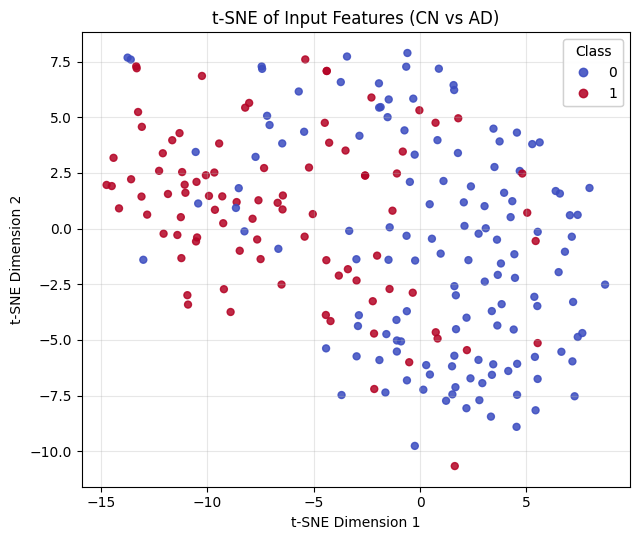

In [ ]:
# ============================
# t-SNE Visualization (Input Features)
# ============================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ---- Input features ----
# X can be numpy or torch
if isinstance(X, torch.Tensor):
    X_input = X.cpu().numpy()
else:
    X_input = X

# ---- Labels ----
if isinstance(y, torch.Tensor):
    labels = y.cpu().numpy()
else:
    labels = y

# ---- Run t-SNE on input features ----
tsne_input = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=42
)

X_2d = tsne_input.fit_transform(X_input)

# ---- Plot t-SNE (Input Space) ----
plt.figure(figsize=(6.5, 5.5))

scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap="coolwarm",
    s=25,
    alpha=0.85
)

# ---- Legend ----
legend = plt.legend(
    *scatter.legend_elements(),
    title="Class",
    loc="best"
)
plt.gca().add_artist(legend)

# ---- Formatting ----
plt.title("t-SNE of Input Features (CN vs AD)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


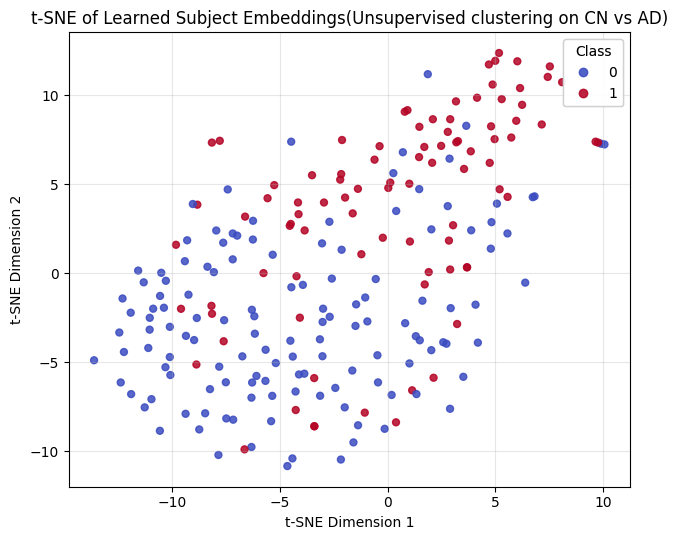

In [ ]:
# ============================
# t-SNE Visualization
# ============================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---- Ensure model is in eval mode ----
model.eval()

# ---- Extract embeddings from full graph ----
with torch.no_grad():
    embeddings = model.online_encoder(data0)   # shape: [N, hidden_dim]
    embeddings = embeddings.cpu().numpy()

# ---- Convert labels to numpy ----
if isinstance(y, torch.Tensor):
    labels = y.cpu().numpy()
else:
    labels = y

# ---- Run t-SNE ----
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    # n_iter=1000,
    init="pca",
    random_state=42
)

embeddings_2d = tsne.fit_transform(embeddings)

# ---- Plot t-SNE ----
plt.figure(figsize=(6.5, 5.5))

scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    cmap="coolwarm",
    s=25,
    alpha=0.85
)

# ---- Legend ----
legend = plt.legend(
    *scatter.legend_elements(),
    title="Class",
    loc="best"
)
plt.gca().add_artist(legend)

# ---- Formatting ----
plt.title("t-SNE of Learned Subject Embeddings(Unsupervised clustering on CN vs AD)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as nnFn
# from torch.optim.lr_scheduler import StepLR
# from torch.optim import AdamW
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
# from torch_geometric.data import Data
# import random
# import scipy.sparse as sp

# # -------------------- Hyperparameters --------------------
# num_runs = 10
# num_epochs = 5000
# lr = 1e-4
# weight_decay = 1e-4
# lambda_list = [0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.9, 1, 2, 5, 8]
# base_seed = 42

# # -------------------- Initialize results storage --------------------
# all_results = []

# # -------------------- Loop over different lambda values --------------------
# for lam in lambda_list:
#     print(f"\n================ LAMBDA = {lam} ================\n")

#     acc_scores = []
#     prec_scores = []
#     rec_scores = []
#     f1_scores = []
#     log_losses = []

#     for run in range(num_runs):
#         print(f"\n--- Run {run+1}/{num_runs} ---")
#         torch.manual_seed(run)
#         np.random.seed(run)
#         random.seed(run)

#         # -------------------- Initialize model and optimizer --------------------
#         model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)
#         optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#         scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

#         # -------------------- Training loop --------------------
#         for epoch in range(num_epochs):

#             # --- Augmentation for adjacency ---
#             W_aug1 = aug_random_edge(W0, drop_percent=0.2, seed=epoch)  # drop edges
#             W_aug2 = aug_subgraph(features, sp.csr_matrix(W0), drop_percent=0.2)[1]  # subgraph

#             # --- Augmentation for features ---
#             features_aug1 = aug_feature_dropout(features, drop_percent=0.2, seed=epoch)
#             features_aug2 = aug_feature_dropout_cell(torch.from_numpy(features), drop_percent=0.2).numpy()

#             # --- Load data for PyG ---
#             node_feats1, edge_index1, _ = load_data(W_aug1, features_aug1)
#             node_feats2, edge_index2, _ = load_data(W_aug2, features_aug2)
#             data1 = Data(x=node_feats1, edge_index=edge_index1).to(device)
#             data2 = Data(x=node_feats2, edge_index=edge_index2).to(device)

#             # --- Training step ---
#             model.train()
#             optimizer.zero_grad()

#             S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

#             unsup_loss = model.loss(A1, logits1)
#             cont_loss = ((l1 + l2) / 2).mean()
#             total_loss = unsup_loss + lam * cont_loss

#             total_loss.backward()
#             optimizer.step()
#             scheduler.step()
#             model.update_ma()

#             if epoch % 500 == 0:
#                 print(f"Epoch {epoch} | Total: {total_loss:.4f} | Unsup: {unsup_loss:.4f} | Cont: {cont_loss:.4f}")

#         # -------------------- Evaluation --------------------
#         model.eval()
#         with torch.no_grad():
#             S1, _, logits1, _, _, _ = model(data0, data0)
#             y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
#             y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()

#             acc_score = accuracy_score(y, y_pred)
#             acc_score_inverted = accuracy_score(y, 1 - y_pred)
#             if acc_score_inverted > acc_score:
#                 acc_score = acc_score_inverted
#                 y_pred = 1 - y_pred

#             print(f"Run {run+1} Accuracy: {acc_score:.4f}")

#             prec_score = precision_score(y, y_pred)
#             rec_score = recall_score(y, y_pred)
#             f1 = f1_score(y, y_pred)
#             log_loss_value = log_loss(y, y_pred_proba)

#             acc_scores.append(acc_score)
#             prec_scores.append(prec_score)
#             rec_scores.append(rec_score)
#             f1_scores.append(f1)
#             log_losses.append(log_loss_value)

#     # -------------------- Store results for this lambda --------------------
#     lambda_results = {
#         "lambda": lam,
#         "accuracy": (np.mean(acc_scores), np.std(acc_scores)),
#         "precision": (np.mean(prec_scores), np.std(prec_scores)),
#         "recall": (np.mean(rec_scores), np.std(rec_scores)),
#         "f1": (np.mean(f1_scores), np.std(f1_scores)),
#         "log_loss": (np.mean(log_losses), np.std(log_losses))
#     }
#     all_results.append(lambda_results)

#     print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
#     print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
#     print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
#     print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
#     print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
#     print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# # -------------------- Final Summary --------------------
# print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
# print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
# print("-" * 108)
# for res in all_results:
#     print(f"{res['lambda']:>8} | "
#           f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
#           f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
#           f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
#           f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
#           f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")
